# Interactive Visualizion with Open Altimetry & Google Earth Engine

## Learning Objectives
- Load ICESat-2 data using the OpenAltimetry API. 
- Query Google Earth Engine for geospatial raster data and display it along with ICESat-2 ground tracks on an interactive map.
- Better understand what you are looking at in ATL03 features without downloading a bunch of files.

## Computing environment

We'll be using the following Python libraries in this notebook:

In [1]:
%matplotlib widget
import os
import ee
import geemap
import requests
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime
from datetime import timedelta
# import rasterio as rio
# from rasterio import plot
# from rasterio import warp
import h5py
import pandas as pd

from datetime import datetime

import datetime as dt

import scipy.stats

import os
import shutil

# import icepyx as ipx

import warnings
warnings.filterwarnings('ignore')

    
The import below is a class that I wrote myself. It helps us read and store data from the OpenAltimetry API.  
If you are interested in how this works, you can find the code in `utils/oa.py`.

## Google Earth Engine Authentication and Initialization
GEE requires you to authenticate your access, so if `ee.Initialize()` does not work you first need to run `ee.Authenticate()`. This gives you a link at which you can use your google account that is associated with GEE to get an authorization code. Copy the authorization code into the input field and hit *enter* to complete authentication. 

In [2]:
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

## Download ATL10 files using icepyx

####  Read the list of ATL10 and Sentinel-2 pairs.

In [3]:
region = "Amundsen"
csvfile = "F:\\IS2_floes\\Overlapped_ATL10_S2_{0}_2018-09-01_2022-03-31.csv".format(region)
# csvfile = "F:\\IS2_floes\\Overlapped_ATL10_S2_{0}_2018-2022.csv".format(region)
filelist = pd.read_csv(csvfile, index_col = 0)

short_name = 'ATL10'

IS2_files = filelist.groupby(by = 'IS2_file', as_index = False).first()
IS2_files['start_date'] = pd.to_datetime(IS2_files['start_date'])
IS2_files['end_date'] = pd.to_datetime(IS2_files['end_date'])

print(region)
print(len(IS2_files))
IS2_files.head(5)

Amundsen
111


,IS2_file,S1_id,start_date,end_date,track,cycle
0,ATL10-02_20190106173443_01420201_005_02.h5,COPERNICUS/S2_SR/20190106T154319_20190106T1543...,2019-01-06,2019-01-07,142,2
1,ATL10-02_20190111200916_02200201_005_02.h5,COPERNICUS/S2_SR/20190111T181509_20190111T1815...,2019-01-11,2019-01-12,220,2
2,ATL10-02_20190125171848_04320201_005_02.h5,COPERNICUS/S2_SR/20190125T161339_20190125T1613...,2019-01-25,2019-01-26,432,2
3,ATL10-02_20190126165310_04470201_005_02.h5,COPERNICUS/S2_SR/20190126T154319_20190126T1543...,2019-01-26,2019-01-27,447,2
4,ATL10-02_20190127162732_04620201_005_02.h5,COPERNICUS/S2_SR/20190127T151259_20190127T1512...,2019-01-27,2019-01-28,462,2


####  NOTE: Once you download all the ATL10 files in the filelist, you can skip the cell below.

In [ ]:
earthdata_uid = 'younghyunkoo' # Your earthdata id
email = 'kooala317@gmail.com' # Your earthdata email
# pswd = getpass.getpass('Earthdata Login password: ')

if region == "Amundsen":
    spatial_extent = [-150, -75, -100, -65] # Amundsen Sea
elif region == "Ross":
    spatial_extent = [-180, -78, -140, -70] # Ross Sea
elif region == "Weddell":
    spatial_extent = [-65, -77, -10, -60] # Weddell Sea
    
# Usage lower latitude images 

for i in range(5, len(IS2_files)):
    
    date_range = [IS2_files['start_date'][i].strftime("%Y-%m-%d"), IS2_files['end_date'][i].strftime("%Y-%m-%d")]
    track = str(IS2_files['track'][i])
    cycle = str(IS2_files['cycle'][i])

    product = ipx.Query(product=short_name, spatial_extent=spatial_extent, date_range=date_range, tracks = track)
    print(product.avail_granules(ids=True)[0])

    product.earthdata_login(earthdata_uid, email)
    product.order_granules()

    path = "F:\\IS2_floes\\ATL10\\{0}".format(region) # Please put your path you want to download
    product.download_granules(path)
        


## Visualize ATL10 data and overlapped Sentinel-2 RGB image (new version)

In [171]:
print("Valid k values: [{0}, {1}]".format(0, len(IS2_files)-1))

Valid k values: [0, 110]


In [44]:
# PLEASE CHANGE THIS K VALUE ==========================================
k = 110 # Index of your IS2 file in your directory

# WEDDELL: 3*, 4, (5), 6*, 7*, 8*, 9, 10, 18, 19*, 22, (24), (26), 30*, (32), 33*, 35, 36, (45), 46, 47,
#          51, 52*, 56*, 59, 62, 66*, 69*, 73, 74*, 75*, 87*, 92,
#          101, 103*, (109), 113, (114), 116*, (117), 118*, 119*, (123), (124), 125, 129, 131*, 132*, (135),  
#          136, 137, 138*, (139), 140, 146, 147*, 148, (151), 165, 168*, 169, 172, 176*, 190, (194), 200*, 201*.

# ROSS: 1*, 7, 10*, (11), (12), (13), (15), 16, 17*, 22, 23*, (24), 25, 27, 31, 32, (33), 38*, 40, 41, 42,
#       43, 47, 48, 49, 50*, 52, 53*, 60, (63), (64), (65), (66), (67), (68), 70, (71), (72), 73, 74*, 75, 76,
#       77, (78), 83, 84, (86), 89, 97.
# In March images, the sea ice covers are "thin/grey" ice. (e.g. 63-68)

# AMUNDSEN: (0), 6, 14, 20*, (21), 27*, (31), 38, 41*, (43), 47*, 49*, 51, 64, 65, (69), 70*, 71*, (72),
#           78, 79, (80), 88, 89, 90, 91, 94*, 95, (96), 100*, 107, 

# TOTAL 40 pairs
# =====================================================================

# NOTE: IS2 ATL10 files should be downloaded first!!
folder = 'F:\\IS2_floes\\ATL10\\' + region
is2_file = folder + '\\' + IS2_files['IS2_file'][k] # IS2 filename in your directory

date1 = datetime.strptime(is2_file.split("ATL10-02_")[1][:8], "%Y%m%d").strftime("%Y-%m-%d")
date2 = (datetime.strptime(is2_file.split("ATL10-02_")[1][:8], "%Y%m%d") + timedelta(days=1)).strftime("%Y-%m-%d")

overlap = False

print("IS2: ", is2_file)

with h5py.File(is2_file, 'r') as f:
    beam = 'gt1l'
    is2_l = pd.DataFrame(data={'lat': f[beam]['freeboard_beam_segment']['beam_freeboard']['latitude'][:],
                              'lon': f[beam]['freeboard_beam_segment']['beam_freeboard']['longitude'][:],
                              'elev': f[beam]['freeboard_beam_segment']['height_segments']['height_segment_height'][:],
                             'freeboard': f[beam]['freeboard_beam_segment']['beam_freeboard']['beam_fb_height'][:],
                              'type': f[beam]['freeboard_beam_segment']['height_segments']['height_segment_type'][:]
                              })

    beam = 'gt3r'
    is2_r = pd.DataFrame(data={'lat': f[beam]['freeboard_beam_segment']['beam_freeboard']['latitude'][:],
                              'lon': f[beam]['freeboard_beam_segment']['beam_freeboard']['longitude'][:],
                              'elev': f[beam]['freeboard_beam_segment']['height_segments']['height_segment_height'][:],
                             'freeboard': f[beam]['freeboard_beam_segment']['beam_freeboard']['beam_fb_height'][:],
                              'type': f[beam]['freeboard_beam_segment']['height_segments']['height_segment_type'][:],
                              })

    is2_l = is2_l[is2_l['freeboard'] <= 10000].reset_index(drop=True)
    is2_r = is2_r[is2_r['freeboard'] <= 10000].reset_index(drop=True)

Map = geemap.Map(center=(is2_l.lat.mean(), is2_l.lon.mean()), zoom=7)

if (len(is2_l) > 0) | (len(is2_r) > 0):
    
    track_l = list(zip([is2_l.lon[0], is2_l.lon[int(len(is2_l)/2)], is2_l.lon[len(is2_l)-1]],
                       [is2_l.lat[0], is2_l.lat[int(len(is2_l)/2)], is2_l.lat[len(is2_l)-1]]))

    track_r = list(zip([is2_r.lon[0], is2_r.lon[int(len(is2_r)/2)], is2_r.lon[len(is2_r)-1]],
                       [is2_r.lat[0], is2_r.lat[int(len(is2_r)/2)], is2_r.lat[len(is2_r)-1]]))

    feature_l = ee.FeatureCollection(ee.Geometry.LineString(coords=track_l, proj='EPSG:4326', geodesic=True))
    feature_r = ee.FeatureCollection(ee.Geometry.LineString(coords=track_r, proj='EPSG:4326', geodesic=True)) 

    S2_ids = filelist[filelist['IS2_file'] == IS2_files['IS2_file'][k]]['S1_id'].values   

    buf_dist = 50000 # buffer distance to check (meter)
    buffer = feature_r.geometry().buffer(buf_dist) 
    
    count = 0

    for S2_id in S2_ids:
        count += 1
        img = ee.Image(S2_id)

        Map.addLayer(img, {'band': ['B4', 'B3', 'B2'], 'min': 0, 'max': 10000}, S2_id)            

        clipped = img.clip(buffer)
        check = len(clipped.getInfo()['properties']['system:footprint']['coordinates'])

        if check > 0:

            overlap = True                
            print(count, " [YES] ", S2_id)

            pan = img.select('B4').add(img.select('B3')).add(img.select('B2'))
            pan = ee.Image.int(pan.divide(3).rename('PAN'))
            img = img.addBands(pan)  

            # Option B (recommended): Download image with a direct link =======================
            downloadURL = img.select(['PAN']).getDownloadUrl({'name': S2_id,
                              'crs': 'EPSG:3412',
                              'scale': 50,
                              'region': img.geometry(),
                              'filePerBand': True,
                              'format': "GEO_TIFF"})

            print("Link to download: ", downloadURL)                

        else:
            print(count, " [NO]", S2_id)               


    Map.addLayer(feature_l, {'color': 'red'}, "left")
    Map.addLayer(feature_r, {'color': 'red'}, "right")
    #         Map.addLayer(buffer, {'color': 'red'}, "buffer")

else:
    print("IS2 file is not valid")
    
Map

IS2:  F:\IS2_floes\ATL10\Amundsen\ATL10-02_20220112144159_03261401_005_01.h5
1  [YES]  COPERNICUS/S2_SR/20220112T162339_20220112T162341_T09CWS
Link to download:  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/752e69e229e8002fb48c1e03b6c4a1c3-c56181302abf406f9de6d6aada4cf5fb:getPixels
2  [YES]  COPERNICUS/S2_SR/20220112T162339_20220112T162341_T09CWT
Link to download:  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d97e7e805b65b1254dddd76c491c25c7-8d46377bc80c2f8cd12d89e4f2c53e9d:getPixels


Map(center=[-68.28351467713118, -5.123642167520839], controls=(WidgetControl(options=['position'], widget=HBox…

In [97]:
is2_file

'F:\\IS2_floes\\ATL10\\Ross\\ATL10-02_20191123170246_08830501_005_02.h5'

## Visualize ATL10 data and overlapped Sentinel-2 RGB image (old version)
### With old version of overlaps data

In [243]:
print("Valid k values: [{0}, {1}]".format(0, len(IS2_files)))

Valid k values: [0, 78]


In [12]:
# PLEASE CHANGE THIS K VALUE ==========================================
k = 66 # Index of your IS2 file in your directory
# WEDDELL: 5, 6, 9, 10, 14, 15, 17, 21, 24, 26, 28, 37, 38, 39, 45, 46, 47, 48, 53, 54, 63, 66* => 22
# ROSS: 1, 3, 7, 14, 17 => 5
# AMUNDSEN: 1, 5, 12, 13, 16, (18), (20), 24, 25, 28, 29*, 30, 35, 37, 41* => 13

# TOTAL 40 pairs
# =====================================================================

# NOTE: IS2 ATL10 files should be downloaded first!!
folder = 'F:\\IS2_floes\\ATL10\\' + region
is2_file = folder + '\\' + IS2_files['IS2_file'][k] # IS2 filename in your directory

date1 = datetime.strptime(is2_file.split("ATL10-02_")[1][:8], "%Y%m%d").strftime("%Y-%m-%d")
date2 = (datetime.strptime(is2_file.split("ATL10-02_")[1][:8], "%Y%m%d") + timedelta(days=1)).strftime("%Y-%m-%d")

beams = ['gt2r'] # List of beams you want to check
overlap = False

for beam in beams:
    print("IS2: ", is2_file)
    with h5py.File(is2_file, 'r') as f:
        is2 = pd.DataFrame(data={'lat': f[beam]['freeboard_beam_segment']['beam_freeboard']['latitude'][:],
                                  'lon': f[beam]['freeboard_beam_segment']['beam_freeboard']['longitude'][:],
                                  'elev': f[beam]['freeboard_beam_segment']['height_segments']['height_segment_height'][:],
                                 'freeboard': f[beam]['freeboard_beam_segment']['beam_freeboard']['beam_fb_height'][:],
                                  'type': f[beam]['freeboard_beam_segment']['height_segments']['height_segment_type'][:],
                                  'x': f[beam]['freeboard_beam_segment']['beam_freeboard']['seg_dist_x'][:]})

        is2 = is2[is2['freeboard'] <= 10000].reset_index(drop=True)
#         is2 = is2[(is2['lat'] <= -71.4) & (is2['lat'] > -71.6)].reset_index(drop=True)
        is2['x'] = is2['x'] - is2['x'].min()
        
    Map = geemap.Map(center=(is2.lat.mean(), is2.lon.mean()), zoom=7)
    
    if len(is2) > 0:       

        ground_track_coordinates = list(zip([is2.lon[0], is2.lon[len(is2)-1]],
                                            [is2.lat[0], is2.lat[len(is2)-1]]))
        ground_track_projection = 'EPSG:4326' # <-- this specifies that our data longitude/latitude in degrees [https://epsg.io/4326]
        # gtx_feature = ee.FeatureCollection(ee.Geometry.MultiPoint(coords=ground_track_coordinates, 
        #                                       proj=ground_track_projection), {key: 'val1'})

        gtx_feature = ee.FeatureCollection(ee.Geometry.LineString(coords=ground_track_coordinates, 
                                              proj=ground_track_projection, 
                                              geodesic=True))

        buf_dist = 50000 # buffer distance to check (meter)
        buffer = gtx_feature.geometry().buffer(buf_dist) 

        S2_ids = filelist[filelist['IS2_file'] == IS2_files['IS2_file'][k]]['S1_id'].values

        for S2_id in S2_ids:
            img = ee.Image(S2_id)
            Map.addLayer(img, {'band': ['B4', 'B3', 'B2'], 'min': 0, 'max': 10000}, S2_id)
            
            # Check if the S2 image and IS2 data is overlapped
            clipped = img.clip(buffer)
            check = len(clipped.getInfo()['properties']['system:footprint']['coordinates'])

            if check > 0:
                overlap = True                
                print("YES: ", S2_id)
                
                # Option A: Download image into Google Drive =====================================
#                 task = ee.batch.Export.image.toDrive(
#                     image = img.select(['B4', 'B3', 'B2']),
#                     description = os.path.basename(S2_id),
#                     folder = 'S2_images',
#                     region= img.geometry(),
#                     scale = 100,
#                     maxPixels = 1e12
#                 );
                
#                 task.start()
                # Export S2 image if it is overlapped with IS2 within buffer area
                # =================================================================================
                
                # Option B (recommended): Download image with a direct link =======================
                downloadURL = img.select(['B4']).getDownloadUrl({'name': 'mySatelliteImage',
                                  'crs': 'EPSG:3412',
                                  'scale': 50,
                                  'region': img.geometry(),
                                  'filePerBand': False,
                                  'format': 'GEO_TIFF'})

                print("Link to download: ", downloadURL)
                
                
            else:
                print("NO : ", S2_id)               
            

        Map.addLayer(gtx_feature, {'color': 'red'}, beam)
#         Map.addLayer(buffer, {'color': 'red'}, "buffer")
        
    else:
        print("IS2 file is not valid")
    
    print(date1, beam, is2.lat.mean(), is2.lon.mean())
    
Map

IS2:  F:\IS2_floes\ATL10\Weddell\ATL10-02_20191022115216_03910501_005_02.h5
YES:  COPERNICUS/S2_SR/20191022T124909_20191022T124907_T21DXG
Link to download:  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2f77eeb92761431c2280d3b0a200056c-68af7a57afbc48f94e3d99c2d0e9b27a:getPixels
YES:  COPERNICUS/S2_SR/20191022T124909_20191022T124907_T22DDN
Link to download:  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a53d401bfb96ec725c4efcbde6972530-219e38ab60b51ca6aa216ceda9cf0765:getPixels
YES:  COPERNICUS/S2_SR/20191022T124909_20191022T124907_T22DDP
Link to download:  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/17cf22f71266d5053104be09043279d5-cbdb4fac4e39e77aa839aeae48c3e662:getPixels
2019-10-22 gt2r -64.8985449690768 -13.71821667323174


Map(center=[-64.8985449690768, -13.71821667323174], controls=(WidgetControl(options=['position'], widget=HBox(…

In [7]:
Map = geemap.Map()

S2_ids = [
    "COPERNICUS/S2_SR/20210227T155329_20210227T155326_T12CVB",
    "COPERNICUS/S2_SR/20210207T155329_20210207T155325_T12CXE",
    "COPERNICUS/S2_SR/20210207T155329_20210207T155325_T13CDU",
    "COPERNICUS/S2_SR/20210207T155329_20210207T155325_T13CDV"
]

S2_ids = [
    "COPERNICUS/S2_SR/20191113T183459_20191113T183501_T02CNA",
    "COPERNICUS/S2_SR/20191113T183459_20191113T183501_T02CNT",
    "COPERNICUS/S2_SR/20191113T183459_20191113T183501_T02CNU",
    "COPERNICUS/S2_SR/20191113T183459_20191113T183501_T02CNV",
    "COPERNICUS/S2_SR/20191113T183459_20191113T183501_T03CVN",
    "COPERNICUS/S2_SR/20191113T183459_20191113T183501_T03CVP",
    "COPERNICUS/S2_SR/20191113T183459_20191113T183501_T03CVR"
]

for S2_id in S2_ids:
    print(S2_id)
    img = ee.Image(S2_id)
    Map.addLayer(img, {'band': ['B4', 'B3', 'B2'], 'min': 0, 'max': 10000}, S2_id)

    # Option B (recommended): Download image with a direct link =======================
    downloadURL = img.select(['B4']).getDownloadUrl({'name': 'mySatelliteImage',
                      'crs': 'EPSG:3412',
                      'scale': 50,
                      'region': img.geometry(),
                      'filePerBand': False,
                      'format': 'GEO_TIFF'})

    print("Link to download: ", downloadURL)

else:
    print("IS2 file is not valid")

Map

COPERNICUS/S2_SR/20191113T183459_20191113T183501_T02CNA
Link to download:  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e24676e629279b0a907586b8f4e99585-50644b1e75b185da20c1744990051c7a:getPixels
COPERNICUS/S2_SR/20191113T183459_20191113T183501_T02CNT
Link to download:  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/eac2b652a7a978bb31796bcfce488fd3-bfc791e2b2f7b6bc97c7e215ac76dc3f:getPixels
COPERNICUS/S2_SR/20191113T183459_20191113T183501_T02CNU
Link to download:  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/60ee4b4ee0836b48ffe0138d579ae529-88cde4afb887e48ff7d76988ed9b78f7:getPixels
COPERNICUS/S2_SR/20191113T183459_20191113T183501_T02CNV
Link to download:  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2a73b0ab5fa973ed8b4ab9814cbd799c-ad7cc3997176ed71f9fef0b886c5569c:getPixels
COPERNICUS/S2_SR/20191113T183459_20191113T183501_T03CVN
Link to down

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [47]:
from glob import glob
import os

region = "Amundsen"
imglist = sorted(glob("F:\\IS2_floes\\S2\\{0}\\*.tif".format(region)))

imgtimes = []
imgmonths = []
imgyears = []

for img in imglist:
    imgtime = datetime.strptime(os.path.basename(img)[:15], "%Y%m%dT%H%M%S")
    if imgtime not in imgtimes:
        imgtimes.append(imgtime)
        imgmonths.append(imgtime.month)
        imgyears.append(imgtime.year)
        
imginfos = pd.DataFrame({"time": imgtimes, "month": imgmonths, "year": imgyears})
imgsum = imginfos.groupby(by = "month", as_index = False).count()
imgsum

,month,time,year
0,1,4,4
1,2,2,2
2,3,4,4
3,9,1,1
4,10,3,3
5,11,7,7
6,12,6,6


Text(0.5, 1.0, 'Number of S2 images for each month (Amundsen)')

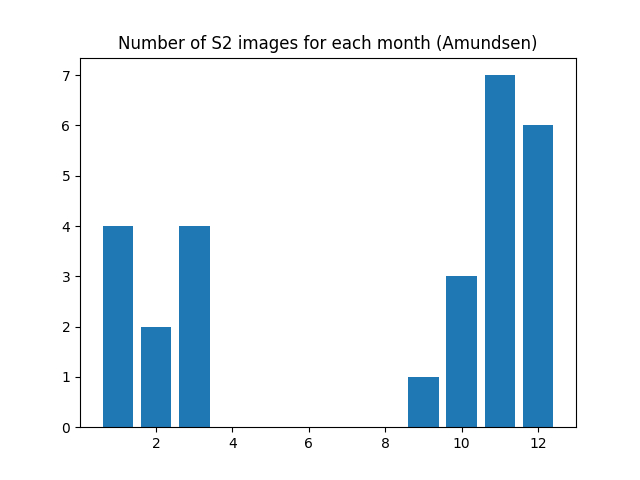

In [48]:
plt.figure()
plt.bar(imgsum["month"], imgsum["time"])
plt.title("Number of S2 images for each month ({0})".format(region))

## References

To further explore the topics of this tutorial see the following detailed documentation:

* [The OpenAltimetry API](https://openaltimetry.org/data/swagger-ui/)
* [Google Earth Engine JavaScript and Python Guides](https://developers.google.com/earth-engine/guides)
* [The geemap package](https://geemap.org/) and [tutorials](https://geemap.org/tutorials/)